# Compustat World Firms Industry Classification

This file was created to make parallesim easier.

##  Import Libraries and Load Datasets

In [21]:
# Data analysis
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import uniform, loguniform
from skopt.space import Real, Categorical, Integer
import pickle


# Preprocessing & Splitting
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.decomposition import PCA

# Modeling
from skopt import BayesSearchCV 
import xgboost
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Utils
from utils import *


In [22]:
compustat = pd.read_pickle('../data/compustat_ftreng.pkl')

In [23]:
compustat.shape

(2748178, 139)

## Model Fitting

### Preprocessing

In [24]:
year_ftrs = ['fyearq','fqtr']
num_ftrs = ['saleq', 'gpq', 'oiadpq', 'oibdpq', 'cogsq',
       'xoprq', 'atq', 'seqq', 'dlcq', 'dlttq', 'capxy', 'oancfy', 'gpm',
       'opm', 'ocfm', 'roa', 'roe', 'cd_ratio', 'ca_ratio', 'fca_ratio',
       'fce_ratio', 'fcd_ratio', 'fcs_ratio', 'tat', 'cr', 'tdr', 'der',
       'gpm_lag1', 'gpm_lag2', 'gpm_lag3', 'gpm_lag4', 'opm_lag1',
       'opm_lag2', 'opm_lag3', 'opm_lag4', 'ocfm_lag1', 'ocfm_lag2',
       'ocfm_lag3', 'ocfm_lag4', 'roa_lag1', 'roa_lag2', 'roa_lag3',
       'roa_lag4', 'roe_lag1', 'roe_lag2', 'roe_lag3', 'roe_lag4',
       'fca_ratio_lag1', 'fca_ratio_lag2', 'fca_ratio_lag3',
       'fca_ratio_lag4', 'fce_ratio_lag1', 'fce_ratio_lag2',
       'fce_ratio_lag3', 'fce_ratio_lag4', 'fcd_ratio_lag1',
       'fcd_ratio_lag2', 'fcd_ratio_lag3', 'fcd_ratio_lag4',
       'fcs_ratio_lag1', 'fcs_ratio_lag2', 'fcs_ratio_lag3',
       'fcs_ratio_lag4', 'tat_lag1', 'tat_lag2', 'tat_lag3', 'tat_lag4',
       'cr_lag1', 'cr_lag2', 'cr_lag3', 'cr_lag4', 'tdr_lag1', 'tdr_lag2',
       'tdr_lag3', 'tdr_lag4', 'der_lag1', 'der_lag2', 'der_lag3',
       'der_lag4', 'gpm_mean_4Q', 'gpm_std_4Q', 'gpm_mean_8Q',
       'gpm_std_8Q', 'opm_mean_4Q', 'opm_std_4Q', 'opm_mean_8Q',
       'opm_std_8Q', 'ocfm_mean_4Q', 'ocfm_std_4Q', 'ocfm_mean_8Q',
       'ocfm_std_8Q', 'roa_mean_4Q', 'roa_std_4Q', 'roa_mean_8Q',
       'roa_std_8Q', 'roe_mean_4Q', 'roe_std_4Q', 'roe_mean_8Q',
       'roe_std_8Q', 'fca_ratio_mean_4Q', 'fca_ratio_std_4Q',
       'fca_ratio_mean_8Q', 'fca_ratio_std_8Q', 'fce_ratio_mean_4Q',
       'fce_ratio_std_4Q', 'fce_ratio_mean_8Q', 'fce_ratio_std_8Q',
       'fcd_ratio_mean_4Q', 'fcd_ratio_std_4Q', 'fcd_ratio_mean_8Q',
       'fcd_ratio_std_8Q', 'fcs_ratio_mean_4Q', 'fcs_ratio_std_4Q',
       'fcs_ratio_mean_8Q', 'fcs_ratio_std_8Q', 'tat_mean_4Q',
       'tat_std_4Q', 'tat_mean_8Q', 'tat_std_8Q', 'cr_mean_4Q',
       'cr_std_4Q', 'cr_mean_8Q', 'cr_std_8Q', 'tdr_mean_4Q',
       'tdr_std_4Q', 'tdr_mean_8Q', 'tdr_std_8Q', 'der_mean_4Q',
       'der_std_4Q', 'der_mean_8Q', 'der_std_8Q']

#cat_ftrs = ['loc','curcdq']  # maybe not include country for now
cat_ftrs = ['curcdq'] 


In [25]:
minmax_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=True, handle_unknown='ignore'))])
preprocessor1 = ColumnTransformer(
    transformers=[
        ('minmax', minmax_transformer, year_ftrs),
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

numeric_transformer2 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))])
categorical_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])
preprocessor2 = ColumnTransformer(
    transformers=[
        ('minmax', minmax_transformer, year_ftrs),
        ('num', numeric_transformer2, num_ftrs),
        ('cat', categorical_transformer2, cat_ftrs)])

Preprocessor suitable for XGBoost, will produce missing values

Preprocessor2 is for random forest, LR, etc. It will fill missing values with 0

### Hyperparameter tuning w/ RandomizedSearchCV

In [32]:

def ML_BayesSearch_CV(X_og, y_og, groups_og, preprocessor, ML_algo, search_space, sample_size=None):
    # Loop for 5 random states
    # in each loop, split, preprocess, fit, and score
    random_states = [377, 575, 610, 777, 233]

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    reports = []
    cms = []
    best_param = []
    best_score = []

    for i in range(1):
        this_rs = random_states[i]
        
        # Split into [train,val] and test sets (80%, 20%)
        sgss = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=this_rs)
        splits = enumerate(sgss.split(X_og, y_og, groups_og))

        print('Splitting dataset into train-val and test sets (80%, 20%)')
        i, (train_val_idx, test_idx) = next(splits)
        X_train_val, X_test = X_og.iloc[train_val_idx], X_og.iloc[test_idx]
        y_train_val, y_test = y_og.iloc[train_val_idx], y_og.iloc[test_idx]
        group_train_val, group_test = groups_og.iloc[train_val_idx], groups_og.iloc[test_idx]


        #full_length = len(y_train_val)
        # After getting test set, downsample train-val 
        if sample_size is None:
            pass
        elif sample_size <= 0.3*0.8:
            print('Sampling dataset for hyperparameter tuning, sample size of train set (80%): ', sample_size*100,'%')
            flat_idx = downsample_classes(y_train_val, group_train_val, random_state=this_rs)
            flat_X, flat_y, flat_groups = X_train_val.iloc[flat_idx], y_train_val.iloc[flat_idx], group_train_val.iloc[flat_idx]
            flat_prop = len(flat_idx)/len(y_train_val)
            if int(flat_prop/sample_size)<=1: # no need to do more sampling
                X, y = flat_X, flat_y
                groups = flat_groups
            else:
                sampler = StratifiedGroupKFold(n_splits=int(flat_prop/sample_size), shuffle=True, random_state=this_rs)
                splits = enumerate(sampler.split(flat_X, flat_y, flat_groups))
                i, (_, sampled_idx) = next(splits)
                X, y = flat_X.iloc[sampled_idx], flat_y.iloc[sampled_idx]
                groups = flat_groups.iloc[sampled_idx]
        else:
            pass
        X_train_val, y_train_val, group_train_val = X, y, groups
                

        # Split [train,val] into train and val sets (64%, 16%)
        sgss_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=this_rs)
        pipe = make_pipeline(preprocessor, 
                             PCA(n_components=0.95, random_state=this_rs),
                             ML_algo)
        print('Random State Loop: ', i+1)
        print('Random State: ', this_rs)
        print('***Start Bayes Search***')

        bayes_search = BayesSearchCV(estimator=pipe,
                                    search_spaces=search_space,
                                    n_iter=20,  # Number of iterations
                                    cv=sgss_cv,       # Cross-validation strategy
                                    n_jobs=-1,  # Use all available cores
                                    scoring='f1_weighted',
                                    verbose=1,
                                    random_state=this_rs)


        bayes_search.fit(X_train_val, y_train_val, groups=group_train_val)        
    
        # Make predictions and calculate accuracy on the test set
        y_pred = bayes_search.predict(X_test)
        
        accuracy = accuracy_score(*vote_pred(y_test, y_pred, group_test))
        precision = precision_score(*vote_pred(y_test, y_pred, group_test), average="weighted")
        recall = recall_score(*vote_pred(y_test, y_pred, group_test), average="weighted")
        f1 = f1_score(*vote_pred(y_test, y_pred, group_test), average="weighted")

        report = classification_report(*vote_pred(y_test, y_pred, group_test))
        cm = confusion_matrix(*vote_pred(y_test, y_pred, group_test))

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        reports.append(report)
        cms.append(cm)
        best_param.append(bayes_search.best_params_)
        best_score.append(bayes_search.best_score_)
        
    return accuracy_scores, precision_scores, recall_scores, f1_scores, cms, best_param, best_score

In [33]:
compustat[cat_ftrs] = compustat[cat_ftrs].astype(str)

groups = compustat['gvkey']
y = compustat['gsector_num']
X = compustat.drop(['gvkey','gsector','gsector_num','datafqtr'], axis=1)

X.shape

(2748178, 135)

#### XGBoost

#### Random Forest

#### Support Vector Machine (Multi-class)

In [34]:
search_space_svc = {
    'svc__C': Real(1e-3, 1e+3, 'log-uniform'),
    'svc__kernel': Categorical(['linear', 'rbf', 'sigmoid']),
    'svc__gamma': Real(1e-4, 1e+3, 'log-uniform')
}

svc_clf = SVC()
acc_svc, pre_svc, rec_svc, f1_svc,\
    cm_svc, params_svc, bs_svc = ML_BayesSearch_CV(X, y, groups, preprocessor2, 
                                                    svc_clf, search_space_svc, sample_size=0.003)

svc_results = {
    "accuracy": acc_svc,
    "precision": pre_svc,
    "recall": rec_svc,
    "f1_score": f1_svc,
    "conf_matrix": cm_svc,
    "params": params_svc,
    "best_score": bs_svc
}
with open('../results/svc_results.pkl', 'wb') as file:
    pickle.dump(svc_results, file)

Splitting dataset into train-val and test sets (80%, 20%)
Sampling dataset for hyperparameter tuning, sample size of train set (80%):  0.3 %
Random State Loop:  1
Random State:  377
***Start Bayes Search***
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


/home/ubuntu/miniconda3/envs/data1030/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


/home/ubuntu/miniconda3/envs/data1030/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits


In [35]:
svc_results

{'accuracy': [0.24128276915245608],
 'precision': [0.26348810897838953],
 'recall': [0.24128276915245608],
 'f1_score': [0.2224140396342855],
 'conf_matrix': [array([[ 238,   49,  166,   16,   13,   89,   21,    2,   37,   34,   10],
         [ 305,  192,  632,   65,   46,  134,   15,   15,   24,   62,    8],
         [ 277,   85, 1043,  200,  111,  122,   47,   65,   65,  110,   23],
         [ 295,   48,  717,  245,   54,  116,   47,   93,  113,   46,   13],
         [ 129,   28,  306,  112,   35,   72,   17,   37,   23,   39,    7],
         [ 199,   81,  261,  147,   20,  377,   12,   35,   96,   22,    4],
         [  49,   11,  182,   13,    0,   34,  382,    8,   15,   14,   37],
         [ 376,   51,  592,  326,   51,  205,   15,  103,  113,   43,    2],
         [ 101,   11,  178,   47,    2,   58,   17,   18,   86,   25,    2],
         [  32,   31,   95,    2,    0,   15,   20,    3,   10,   80,    9],
         [  24,    5,   34,    5,    0,    5,   11,    0,    1,    8,   6

In [ ]:
# SAMPLE TEST
#X, y, groups = sample_dataset(X, y, groups, sample_size=0.1)

Referenced this [article](https://towardsdatascience.com/beyond-grid-search-hypercharge-hyperparameter-tuning-for-xgboost-7c78f7a2929d)
to help with hyperparameter tuning for XGBoost.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=this_rs)
for train_val_idx, test_idx in gss.split(X, y, groups):
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
    group_train_val, group_test = groups.iloc[train_val_idx], groups.iloc[test_idx]

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.17, random_state=this_rs)
for train_idx, val_idx in gss2.split(X_train_val, y_train_val, group_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    group_train, group_val = group_train_val.iloc[train_idx], group_train_val.iloc[val_idx]

X_train.shape, X_val.shape, X_test.shape

((1935735, 135), (398159, 135), (414284, 135))

In [ ]:
preprocessor1.fit(X_train)
feature_names = preprocessor1.get_feature_names_out()

X_train = preprocessor1.transform(X_train)
X_val = preprocessor1.transform(X_val)
X_test = preprocessor1.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((1935735, 135), (398159, 135), (414284, 135))

In [ ]:
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df = pd.DataFrame(X_val, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)
#X_train_df.fillna(0, inplace=True)
#X_val_df.fillna(0, inplace=True)
#X_test_df.fillna(0, inplace=True)

In [ ]:
# parameters to try 
from sklearn.model_selection import ParameterGrid
import xgboost

this_rs=233

param_grid = {"learning_rate": [0.02],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBClassifier(objective = "multi:softmax",
                            enable_categorical = True,
                            n_estimators = 500,
                            max_depth = 9,
                            colsample_bytree = 0.75,
                            subsample = 0.65,
                            learning_rate = 0.2, 
                            reg_alpha = 0.4,
                            reg_lambda = 40,
                            eval_metric = 'mlogloss',
                            missing = np.nan,
                            early_stopping_rounds=50,
                            seed = this_rs)

In [ ]:
XGB.fit(X_train,y_train, eval_set=[(X_val, y_val)], verbose=True)


[0]	validation_0-mlogloss:2.25457
[1]	validation_0-mlogloss:2.16163
[2]	validation_0-mlogloss:2.09122
[3]	validation_0-mlogloss:2.03515
[4]	validation_0-mlogloss:1.98907
[5]	validation_0-mlogloss:1.95209
[6]	validation_0-mlogloss:1.92057
[7]	validation_0-mlogloss:1.89464
[8]	validation_0-mlogloss:1.87174
[9]	validation_0-mlogloss:1.85236
[10]	validation_0-mlogloss:1.83506
[11]	validation_0-mlogloss:1.82001
[12]	validation_0-mlogloss:1.80725
[13]	validation_0-mlogloss:1.79614
[14]	validation_0-mlogloss:1.78581
[15]	validation_0-mlogloss:1.77675
[16]	validation_0-mlogloss:1.76883
[17]	validation_0-mlogloss:1.76172
[18]	validation_0-mlogloss:1.75469
[19]	validation_0-mlogloss:1.74872
[20]	validation_0-mlogloss:1.74313
[21]	validation_0-mlogloss:1.73793
[22]	validation_0-mlogloss:1.73340
[23]	validation_0-mlogloss:1.72915
[24]	validation_0-mlogloss:1.72520
[25]	validation_0-mlogloss:1.72190
[26]	validation_0-mlogloss:1.71866
[27]	validation_0-mlogloss:1.71583
[28]	validation_0-mlogloss:1.7

KeyboardInterrupt: 

In [ ]:
# Save the model
#booster = XGB.get_booster()
#booster.save_model('xgb_booster_trained.bin')
XGB.save_model('xgb_trained.json')

In [ ]:
# Load the model
#booster = xgboost.Booster()
#booster.load_model('xgb_booster_trained.bin')
#XGB = xgboost.XGBClassifier()
#XGB.load_model('xgb_trained.json')

In [ ]:
# predict on validation 
y_train_pred = XGB.predict(X_train)
y_val_pred = XGB.predict(X_val)
y_test_pred = XGB.predict(X_test)

In [ ]:
print('Train:')
print_metrics(y_train, y_train_pred)
print('Val:')
print_metrics(y_val, y_val_pred)
print('Test:')
print_metrics(y_test, y_test_pred)

Train:
Accuracy:  0.63
Precision:  0.658
Recall:  0.63
F1:  0.632
Val:
Accuracy:  0.41
Precision:  0.426
Recall:  0.41
F1:  0.406
Test:
Accuracy:  0.421
Precision:  0.434
Recall:  0.421
F1:  0.416


In [ ]:
print('Train:')
print_metrics(*vote_pred(y_train, y_train_pred, group_train))
print('Val:')
print_metrics(*vote_pred(y_val, y_val_pred, group_val))
print('Test:')
print_metrics(*vote_pred(y_test, y_test_pred, group_test))

Train:
Accuracy:  0.7
Precision:  0.738
Recall:  0.7
F1:  0.702
Val:
Accuracy:  0.47
Precision:  0.506
Recall:  0.47
F1:  0.464
Test:
Accuracy:  0.477
Precision:  0.51
Recall:  0.477
F1:  0.47


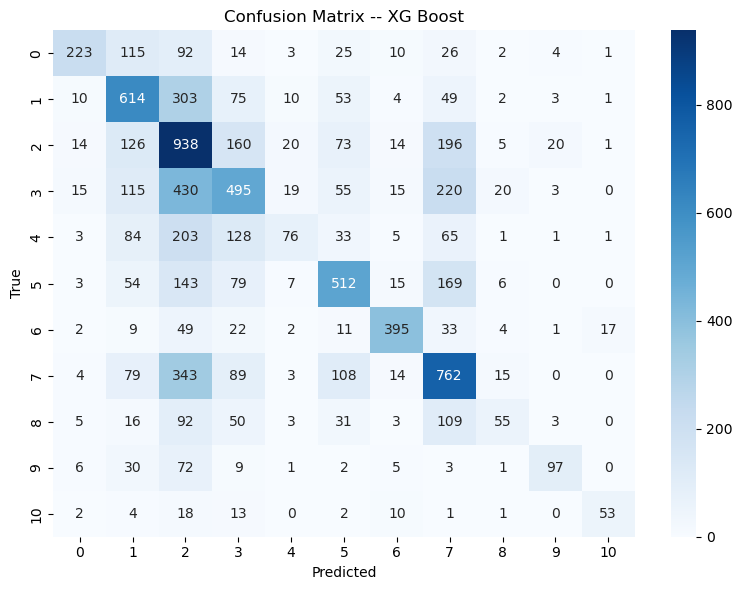

In [ ]:
cm = confusion_matrix(*vote_pred(y_test, y_test_pred, group_test))
# Plotting
fig_xgb_cm = plt.figure(figsize=(8, 6), tight_layout=True)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix -- XG Boost")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
#fig_xgb_cm.savefig('../figures/confusion_matrix_xgb.png', dpi=300)

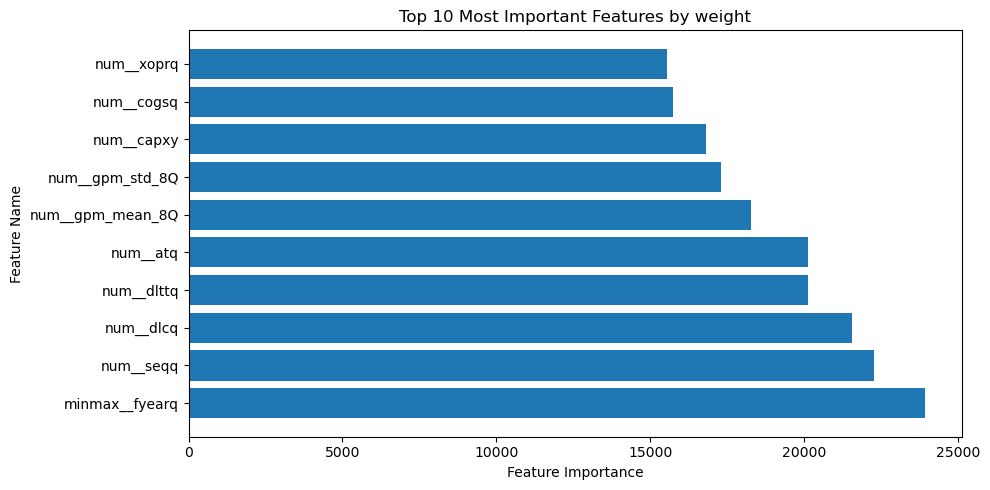

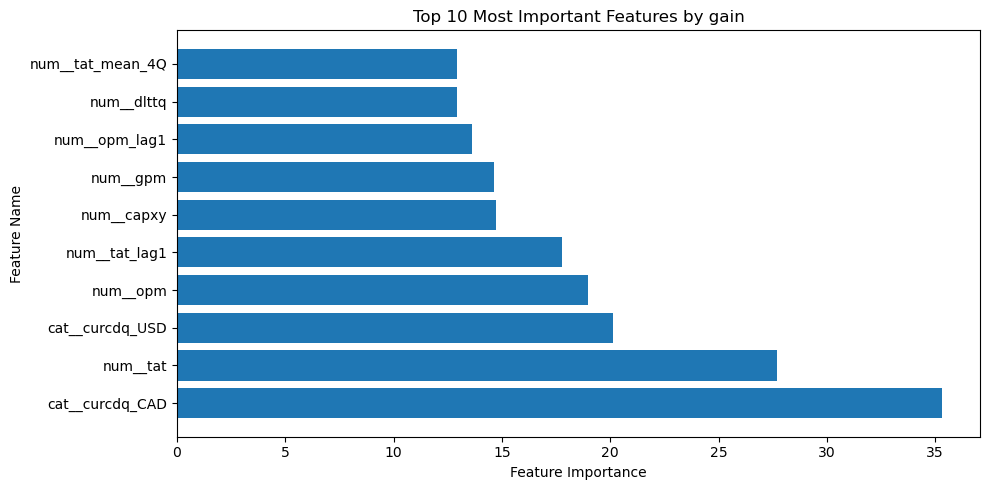

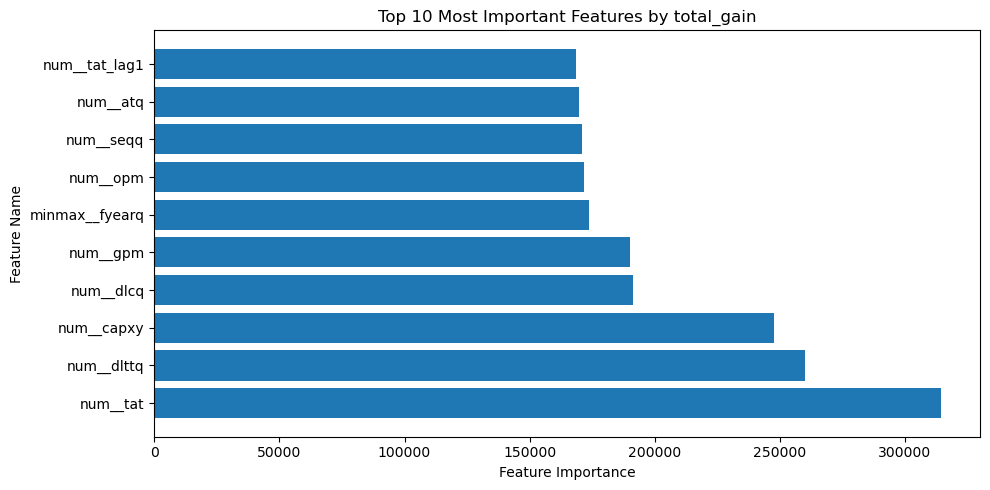

In [ ]:
def xgb_top10_importance(model:xgboost.XGBRegressor, metric:str):
    importance = model.get_booster().get_score(importance_type=metric)
    ftr_name = feature_names
    ftr_importance = np.array(list(importance.values()))
    top10_idx = np.argsort(ftr_importance)[-10:][::-1] # top 10 features, descending order
    plt.figure(figsize=(10,5))
    plt.barh(ftr_name[top10_idx], ftr_importance[top10_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title('Top 10 Most Important Features by '+metric)
    plt.tight_layout()
    plt.show()

xgb_top10_importance(XGB, 'weight')
xgb_top10_importance(XGB, 'gain')
xgb_top10_importance(XGB, 'total_gain')
